In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data directory
import os
os.chdir('/content/drive/MyDrive/Saarland')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# First, let's see what columns are available
mlb_temp = pd.read_csv('mlb_scores.csv', encoding='latin1', nrows=1)
print('Available columns:', mlb_temp.columns.tolist())

# Load data - adjust column names based on what's actually in the file
mlb = pd.read_csv('mlb_scores.csv', encoding='latin1')

mlb.head()

Available columns: ['away_team', 'away_team_score', 'date', 'game_id', 'home_team', 'home_team_score', 'note', 'season', 'year']


,away_team,away_team_score,date,game_id,home_team,home_team_score,note,season,year
0,chw,4,"Tue, Mar 4",300304103.0,laa,4,NaN,Preseason,2010
1,lad,8,"Wed, Mar 5",300305104.0,chw,3,NaN,Preseason,2010
2,chw,15,"Thu, Mar 6",300306116.0,chc,3,NaN,Preseason,2010
3,chw,8,"Thu, Mar 6",300306119.0,lad,4,NaN,Preseason,2010
4,sea,5,"Sat, Mar 8",300308104.0,chw,4,NaN,Preseason,2010


In [4]:
# Parse dates and rename - handle different possible column names
# Check which columns exist and use them
if 'date' in mlb.columns:
    mlb['Date'] = pd.to_datetime(mlb['date'], errors='coerce')
elif 'Date' in mlb.columns:
    mlb['Date'] = pd.to_datetime(mlb['Date'], errors='coerce')

# Flexible column renaming
rename_map = {}
if 'home_team' in mlb.columns:
    rename_map['home_team'] = 'HomeTeam'
if 'away_team' in mlb.columns:
    rename_map['away_team'] = 'AwayTeam'
if 'home_team_score' in mlb.columns:
    rename_map['home_team_score'] = 'HomeScore'
elif 'home_score' in mlb.columns:
    rename_map['home_score'] = 'HomeScore'
if 'away_team_score' in mlb.columns:
    rename_map['away_team_score'] = 'AwayScore'
elif 'away_score' in mlb.columns:
    rename_map['away_score'] = 'AwayScore'
if 'year' in mlb.columns:
    rename_map['year'] = 'Year'

mlb = mlb.rename(columns=rename_map)

# If Year doesn't exist, try to extract from Date
if 'Year' not in mlb.columns and 'Date' in mlb.columns:
    mlb['Year'] = mlb['Date'].dt.year

# Clean scores - remove extra text like 'F/8', 'F/10', etc.
mlb['HomeScore'] = pd.to_numeric(mlb['HomeScore'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')
mlb['AwayScore'] = pd.to_numeric(mlb['AwayScore'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')

# Drop rows with missing scores
mlb = mlb.dropna(subset=['HomeScore', 'AwayScore'])
mlb['HomeScore'] = mlb['HomeScore'].astype(int)
mlb['AwayScore'] = mlb['AwayScore'].astype(int)

# Tag regular season vs other (if season column exists)
if 'season' in mlb.columns:
    mlb['is_regular'] = mlb['season'].str.contains('Regular Season', na=False)
else:
    # If no season column, assume all are regular season
    mlb['is_regular'] = True

print(f"Total games: {len(mlb)}")
print(f"Regular season: {mlb['is_regular'].sum()}")
print(f"Other: {(~mlb['is_regular']).sum()}")
if 'Year' in mlb.columns:
    print(f"Years: {mlb['Year'].min()}-{mlb['Year'].max()}")

Total games: 31399
Regular season: 25523
Other: 5876
Years: 2010-2020


## Calculate Per-Team Win Percentage (Peko's Method)

Following Getty et al. (2018), we calculate win percentage for each team, then use random splits to compute R*.

In [5]:
def get_team_games(df, team):
    """Get all games for a specific team"""
    home_games = df[df['HomeTeam'] == team].copy()
    home_games['is_home'] = True
    home_games['team_score'] = home_games['HomeScore']
    home_games['opp_score'] = home_games['AwayScore']
    home_games['opponent'] = home_games['AwayTeam']

    away_games = df[df['AwayTeam'] == team].copy()
    away_games['is_home'] = False
    away_games['team_score'] = away_games['AwayScore']
    away_games['opp_score'] = away_games['HomeScore']
    away_games['opponent'] = away_games['HomeTeam']

    team_games = pd.concat([home_games, away_games])
    team_games = team_games.sort_values('Date')

    # Calculate wins (1 for win, 0 for loss; no ties in MLB)
    team_games['win'] = (team_games['team_score'] > team_games['opp_score']).astype(int)

    return team_games

def calculate_r_peko_method(df, n_folds=100):
    """
    Calculate R* using Peko's method:
    1. For each team, randomly split games K times
    2. Calculate win percentage for each split
    3. Pool all (x,y) pairs across teams and splits
    4. Transform to S,T coordinates
    5. Calculate R = 1 - var(T)/var(S)
    """
    teams = sorted(set(df['HomeTeam']).union(set(df['AwayTeam'])))

    # Collect all (x,y) pairs
    XY_pairs = []

    for team in teams:
        team_games = get_team_games(df, team)
        n_games = len(team_games)

        # Skip teams with too few games
        if n_games < 4:
            continue

        # Perform K random splits for this team
        for k in range(n_folds):
            # Randomly assign games to fold A or B
            fold = np.random.randint(0, 2, n_games)

            games_a = team_games.iloc[fold == 0]
            games_b = team_games.iloc[fold == 1]

            # Calculate win percentage
            if len(games_a) > 0 and len(games_b) > 0:
                x = games_a['win'].sum() / len(games_a)
                y = games_b['win'].sum() / len(games_b)
                XY_pairs.append((x, y))

    if len(XY_pairs) < 3:
        return np.nan

    # Convert to arrays
    X = np.array([x for x, y in XY_pairs])
    Y = np.array([y for x, y in XY_pairs])

    # Transform to S, T coordinates
    S = (X + Y) / np.sqrt(2)
    T = (Y - X) / np.sqrt(2)

    # Calculate variances (using ddof=0)
    var_S = np.var(S, ddof=0)
    var_T = np.var(T, ddof=0)

    # Calculate R
    if var_S > 1e-12:
        R = 1 - var_T / var_S
    else:
        R = np.nan

    return R

## Calculate R by Season

In [6]:
results = []

for year in sorted(mlb['Year'].unique()):
    year_data = mlb[mlb['Year'] == year]

    # Regular season only
    reg_only = year_data[year_data['is_regular']]

    # All games
    all_games = year_data

    n_teams = len(set(year_data['HomeTeam']).union(set(year_data['AwayTeam'])))

    if len(reg_only) >= 20:
        r_reg = calculate_r_peko_method(reg_only, n_folds=100)
        r_all = calculate_r_peko_method(all_games, n_folds=100)

        results.append({
            'Year': year,
            'N_Teams': n_teams,
            'Games_Regular': len(reg_only),
            'Games_All': len(all_games),
            'R_Regular': r_reg,
            'R_All': r_all
        })

results_df = pd.DataFrame(results)
results_df = results_df.round({'R_Regular': 2, 'R_All': 2})
results_df

,Year,N_Teams,Games_Regular,Games_All,R_Regular,R_All
0,2010,42,2592,3136,0.66,0.69
1,2011,48,2591,3173,0.69,0.65
2,2012,55,2430,2995,0.70,0.66
3,2013,51,2431,3013,0.71,0.69
4,2014,46,2430,2942,0.54,0.60
5,2015,47,2429,2970,0.61,0.57
6,2016,44,2429,2953,0.63,0.62
7,2017,45,2430,3011,0.67,0.68
8,2018,44,2431,2965,0.81,0.81
9,2019,30,2431,2940,0.84,0.82


## Visualize Results

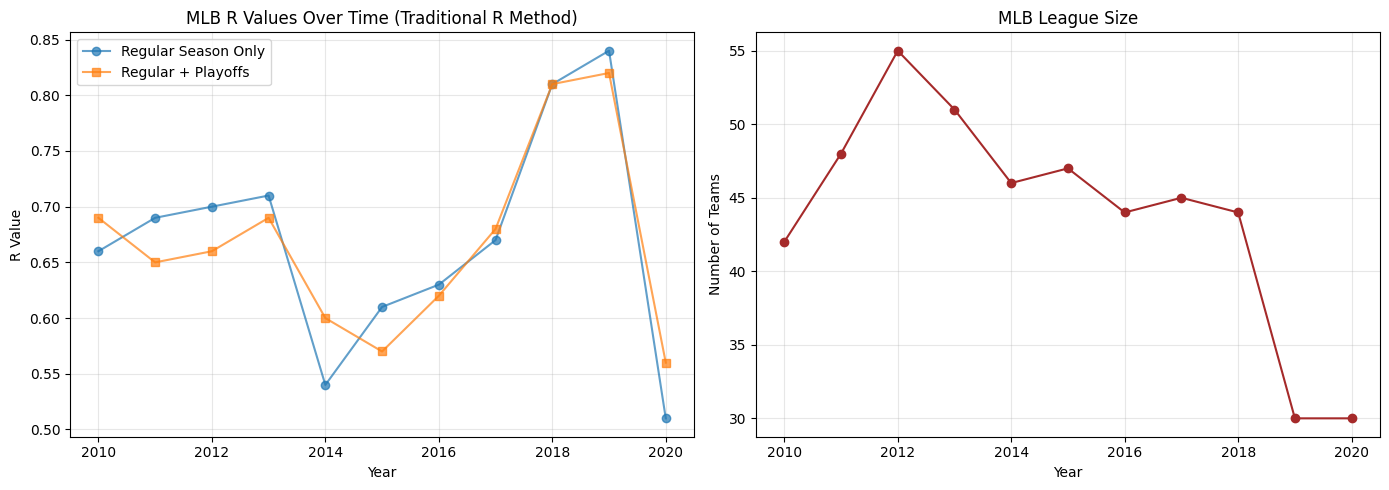

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# R values over time
ax1.plot(results_df['Year'], results_df['R_Regular'], 'o-', label='Regular Season Only', alpha=0.7)
ax1.plot(results_df['Year'], results_df['R_All'], 's-', label='Regular + Playoffs', alpha=0.7)
#ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='R = 0.5')
ax1.set_xlabel('Year')
ax1.set_ylabel('R Value')
ax1.set_title('MLB R Values Over Time (Traditional R Method)')
ax1.legend()
ax1.grid(alpha=0.3)

# Number of teams over time
ax2.plot(results_df['Year'], results_df['N_Teams'], 'o-', color='brown')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Teams')
ax2.set_title('MLB League Size')
ax2.set_yticks(range(min(results_df['N_Teams']), max(results_df['N_Teams']) + 5, 5))
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Summary statistics
print("\nOverall Summary:")
print(f"Mean R (Regular): {results_df['R_Regular'].mean():.3f}")
print(f"Mean R (All): {results_df['R_All'].mean():.3f}")
print(f"Std R (Regular): {results_df['R_Regular'].std():.3f}")
print(f"Std R (All): {results_df['R_All'].std():.3f}")


Overall Summary:
Mean R (Regular): 0.670
Mean R (All): 0.668
Std R (Regular): 0.100
Std R (All): 0.085


## P vs Q Scatter Plot

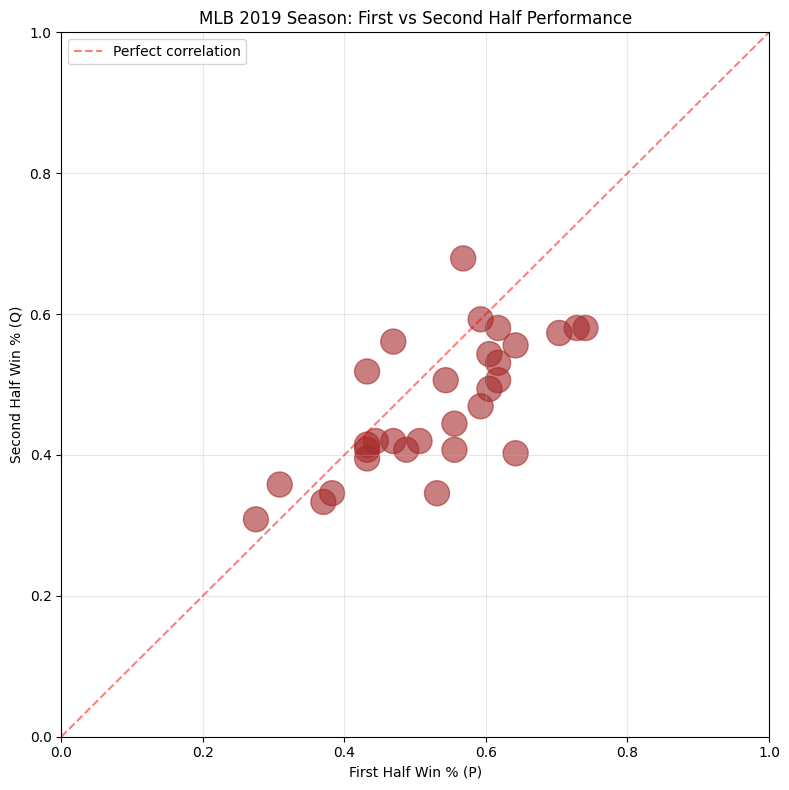


Correlation between first and second half: 0.716


In [9]:
# Analyze a recent season for visualization
example_year = 2019
season_data = mlb[(mlb['Year'] == example_year) & (mlb['is_regular'])]
teams = sorted(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

P_values = []
Q_values = []
game_counts = []

for team in teams:
    team_games = get_team_games(season_data, team)
    n_games = len(team_games)

    if n_games < 4:
        continue

    # Split into first and second half
    half = n_games // 2
    first_half = team_games.iloc[:half]
    second_half = team_games.iloc[half:]

    p = first_half['win'].sum() / len(first_half)
    q = second_half['win'].sum() / len(second_half)

    P_values.append(p)
    Q_values.append(q)
    game_counts.append(n_games)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [g * 2 for g in game_counts]
ax.scatter(P_values, Q_values, s=sizes, alpha=0.6, color='brown')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect correlation')
ax.set_xlabel('First Half Win % (P)')
ax.set_ylabel('Second Half Win % (Q)')
ax.set_title(f'MLB {example_year} Season: First vs Second Half Performance')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between first and second half: {np.corrcoef(P_values, Q_values)[0,1]:.3f}")